# Custom Convolutional Neural Network

In this notebook, we present two of our initial custom models.
While these models performed well on our local test set, their performance was significantly lower on Codabench.

Sections:
1. Import necessary libraries and modules
2. Load cleaned dataset and preprocess it
3. Define models parameters and architecture
4. Train the models
5. Evaluate the models

### 1. Import necessary libraries 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                            recall_score, confusion_matrix, roc_auc_score,
                            classification_report)
from sklearn.preprocessing import label_binarize
import seaborn as sns

SEED = 42


### 2. Load dataset and preprocess 

In [2]:
# Load cleaned dataset
data = np.load('data/training_set_clean.npz', allow_pickle=True)

# Extract images and labels
images = data['images'] # shape (num_samples, height, width, channels)
labels = data['labels'] # Shape: (num_samples,)

# Normalize images to [0, 1] range
images = images / 255.0

# Convert labels to one-hot encoding
num_classes = len(np.unique(labels))
labels = to_categorical(labels, num_classes)

# Split data into training, validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(images, labels, test_size=0.1, random_state=SEED, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15, random_state=SEED, stratify=y_temp)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (9141, 96, 96, 3), (9141, 8)
Validation set: (1614, 96, 96, 3), (1614, 8)
Test set: (1196, 96, 96, 3), (1196, 8)


## MODEL 1

### 3. Define model

In [3]:
# Define model parameters
input_shape = X_train[0].shape
output_shape = y_train[0].shape[0]
learning_rate = 1e-4
batch_size = 32
epochs = 300
patience = 30
dropout_rate = 0.5

# Define models structure
model_1 = models.Sequential([
    layers.Input(shape=input_shape, name='input'),
    layers.Conv2D(16, (3, 3), activation='relu', name='conv1'),
    layers.MaxPooling2D((2, 2), name='maxpool1'),
    layers.Conv2D(32, (3, 3), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='maxpool2'),
    layers.Conv2D(64, (3, 3), activation='relu', name='conv3'),
    layers.Flatten(name='flatten'),
    layers.Dense(128, activation='relu', name='dense1'),
    layers.BatchNormalization(name='batchnorm1'),
    layers.Dropout(dropout_rate, name='dropout1'),
    layers.Dense(64, activation='relu', name='dense2'),
    layers.BatchNormalization(name='batchnorm2'),
    layers.Dropout(dropout_rate, name='dropout2'),
    layers.Dense(output_shape, activation='softmax', name='output')
])

# Compile models
model_1.compile(optimizer=optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model_1.summary()

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=patience,
                                                  restore_best_weights=True)

# Define model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('models/custom_model_1.keras',
                                                         monitor='val_accuracy', 
                                                         save_best_only=True,  
                                                         save_weights_only=False, 
                                                         mode='max')

# Callbacks
callbacks = [early_stopping, checkpoint_callback]

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 47, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm1 (BatchNormalization) │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm2 (BatchNormalization) │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,310,056 (12.63 MB)

 Trainable params: 3,309,672 (12.63 MB)

 Non-trainable params: 384 (1.50 KB)

### 4. Train the model

In [4]:
# Train the model
history = model_1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks).history

print("Training completed.")
print(f"Final validation accuracy: {max(history['val_accuracy']):.4f}")

Epoch 1/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.4072 - loss: 1.8329 - val_accuracy: 0.3773 - val_loss: 1.6079
Epoch 2/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.6754 - loss: 0.9362 - val_accuracy: 0.7924 - val_loss: 0.6558
Epoch 3/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.7456 - loss: 0.7525 - val_accuracy: 0.7057 - val_loss: 0.8838
Epoch 4/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.7777 - loss: 0.6540 - val_accuracy: 0.8172 - val_loss: 0.5536
Epoch 5/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - accuracy: 0.8068 - loss: 0.5641 - val_accuracy: 0.8067 - val_loss: 0.5516
Epoch 6/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.8346 - loss: 0.5103 - val_accuracy: 0.8116 - val_loss: 0.5573
Epoch 7/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 21s 73ms/step - accuracy: 0.8418 - loss: 0.4698 - val_accuracy: 0.8612 - val_loss: 0.4458
Epoch 8/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 19s 67ms/step - accuracy: 0.8770 - loss: 0

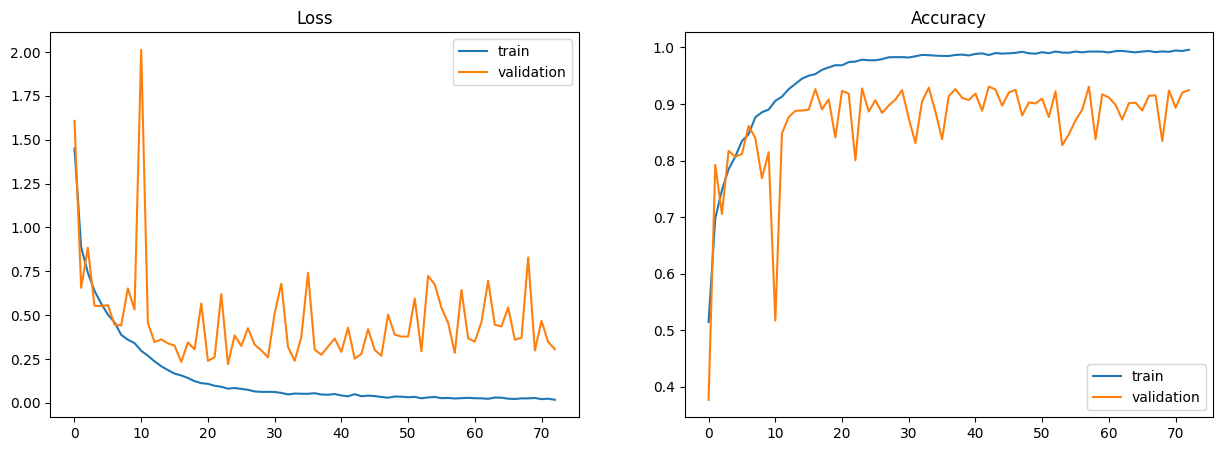

In [5]:
# Visualize training
def plot_training(history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    axs[0].plot(history['loss'], label='train')
    axs[0].plot(history['val_loss'], label='validation')
    axs[0].set_title('Loss')
    axs[0].legend()

    axs[1].plot(history['accuracy'], label='train')
    axs[1].plot(history['val_accuracy'], label='validation')
    axs[1].set_title('Accuracy')
    axs[1].legend()

    plt.show()

plot_training(history)

### 5. Evaluate model

Accuracy score over the normal test set: 0.9306
Precision score over the normal test set: 0.9311
Recall score over the normal test set: 0.9306
F1 score over the normal test set: 0.93


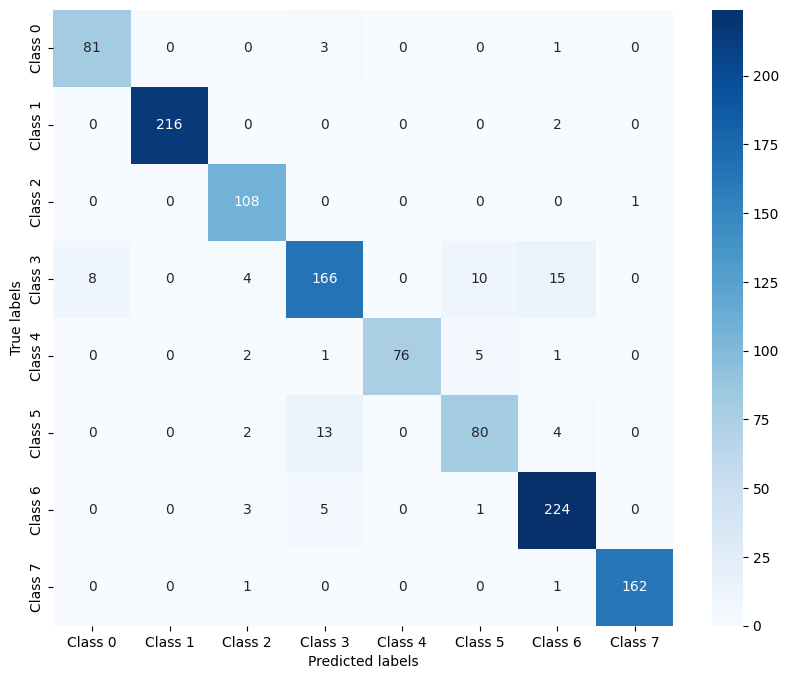


Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.95      0.93        85
           1       1.00      0.99      1.00       218
           2       0.90      0.99      0.94       109
           3       0.88      0.82      0.85       203
           4       1.00      0.89      0.94        85
           5       0.83      0.81      0.82        99
           6       0.90      0.96      0.93       233
           7       0.99      0.99      0.99       164

    accuracy                           0.93      1196
   macro avg       0.93      0.93      0.93      1196
weighted avg       0.93      0.93      0.93      1196

Class 0 ROC-AUC Score: 0.9974
Class 1 ROC-AUC Score: 1.0
Class 2 ROC-AUC Score: 0.999
Class 3 ROC-AUC Score: 0.9823
Class 4 ROC-AUC Score: 0.9988
Class 5 ROC-AUC Score: 0.9939
Class 6 ROC-AUC Score: 0.9962
Class 7 ROC-AUC Score: 0.9999

Mean ROC-AUC Score: 0.9959


In [6]:
# Predict class probabilities and get predicted classes for normal test set
test_predictions = model_1.predict(X_test, verbose=0)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display metrics for the normal test set
test_accuracy = accuracy_score(test_gt, test_predictions_classes)
test_precision = precision_score(test_gt, test_predictions_classes, average='weighted')
test_recall = recall_score(test_gt, test_predictions_classes, average='weighted')
test_f1 = f1_score(test_gt, test_predictions_classes, average='weighted')

print(f'Accuracy score over the normal test set: {round(test_accuracy, 4)}')
print(f'Precision score over the normal test set: {round(test_precision, 4)}')
print(f'Recall score over the normal test set: {round(test_recall, 4)}')
print(f'F1 score over the normal test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions_classes)

# Plot the confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=[f'Class {i}' for i in range(8)],
            yticklabels=[f'Class {i}' for i in range(8)], cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Classification report for detailed metrics per class
print("\nClassification Report:\n")
print(classification_report(test_gt, test_predictions_classes))

# ROC-AUC score for each class
y_test_binarized = label_binarize(test_gt, classes=range(8))
roc_auc_scores = []
for i in range(8):
    try:
        roc_auc = roc_auc_score(y_test_binarized[:, i], test_predictions[:, i])
        roc_auc_scores.append(roc_auc)
        print(f"Class {i} ROC-AUC Score: {round(roc_auc, 4)}")
    except ValueError:
        print(f"Class {i} ROC-AUC Score: Unable to calculate (not enough samples).")

# Display mean ROC-AUC score across classes
if roc_auc_scores:
    print(f"\nMean ROC-AUC Score: {round(np.mean(roc_auc_scores), 4)}")

## MODEL 2

### 3. Define model

In [7]:

# Define model parameters
input_shape = X_train[0].shape
output_shape = y_train[0].shape[0]
learning_rate = 1e-4
batch_size = 32
epochs = 300
patience = 30

# Define model structure
model_2 = models.Sequential([
    layers.Input(shape=input_shape, name='input'),
    layers.Conv2D(32, (5, 5), activation='relu', name='conv1'),
    layers.MaxPooling2D((2, 2), name='maxpool1'),
    layers.BatchNormalization(name='batchnorm1'),
    layers.Dropout(0.22, name='dropout1'),
    layers.Conv2D(32, (5, 5), activation='relu', name='conv2'),
    layers.MaxPooling2D((2, 2), name='maxpool2'),
    layers.BatchNormalization(name='batchnorm2'),
    layers.Dropout(0.25, name='dropout2'),
    layers.Conv2D(32, (4, 4), activation='relu', name='conv3'),
    layers.MaxPooling2D((2, 2), name='maxpool3'),
    layers.BatchNormalization(name='batchnorm3'),
    layers.Dropout(0.15, name='dropout3'),
    layers.Conv2D(32, (3, 3), activation='relu', name='conv4'),
    layers.MaxPooling2D((2, 2), name='maxpool4'),
    layers.BatchNormalization(name='batchnorm4'),
    layers.Dropout(0.15, name='dropout4'),
    layers.Flatten(name='flatten'),
    layers.Dense(256, activation='relu', name='dense1'),
    layers.Dense(64, activation='relu', name='dense2'),
    layers.Dense(output_shape, activation='softmax', name='output')
])

# Compile model
model_2.compile(optimizer=optimizers.Adam(learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Show model summary
model_2.summary()

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                  patience=patience,
                                                  restore_best_weights=True)

# Define model checkpoint callback
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('models/custom_model_2.keras',
                                                         monitor='val_accuracy', 
                                                         save_best_only=True,  
                                                         save_weights_only=False, 
                                                         mode='max')

callbacks = [early_stopping, checkpoint_callback]

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 92, 92, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool1 (MaxPooling2D)         │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm1 (BatchNormalization) │ (None, 46, 46, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 42, 42, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool2 (MaxPooling2D)         │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm2 (BatchNormalization) │ (None, 21, 21, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3 (Conv2D)                  │ (None, 18, 18, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool3 (MaxPooling2D)         │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm3 (BatchNormalization) │ (None, 9, 9, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout3 (Dropout)              │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4 (Conv2D)                  │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool4 (MaxPooling2D)         │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batchnorm4 (BatchNormalization) │ (None, 3, 3, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout4 (Dropout)              │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 256)            │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense2 (Dense)                  │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 145,192 (567.16 KB)

 Trainable params: 144,936 (566.16 KB)

 Non-trainable params: 256 (1.00 KB)

### 4. Train the model

In [8]:
# Train the model
history = model_2.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    callbacks=callbacks).history

print("Training completed.")
print(f"Final validation accuracy: {max(history['val_accuracy']):.4f}")

Epoch 1/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 40s 127ms/step - accuracy: 0.4966 - loss: 1.4178 - val_accuracy: 0.1375 - val_loss: 6.4121
Epoch 2/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 39s 135ms/step - accuracy: 0.8306 - loss: 0.4951 - val_accuracy: 0.1945 - val_loss: 4.0398
Epoch 3/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - accuracy: 0.8687 - loss: 0.3716 - val_accuracy: 0.3879 - val_loss: 2.1780
Epoch 4/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - accuracy: 0.8894 - loss: 0.3182 - val_accuracy: 0.6859 - val_loss: 0.9255
Epoch 5/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - accuracy: 0.9045 - loss: 0.2787 - val_accuracy: 0.5886 - val_loss: 1.4035
Epoch 6/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - accuracy: 0.9054 - loss: 0.2707 - val_accuracy: 0.7454 - val_loss: 0.7856
Epoch 7/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 36s 127ms/step - accuracy: 0.9168 - loss: 0.2412 - val_accuracy: 0.6580 - val_loss: 1.0673
Epoch 8/300
286/286 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.9173 -

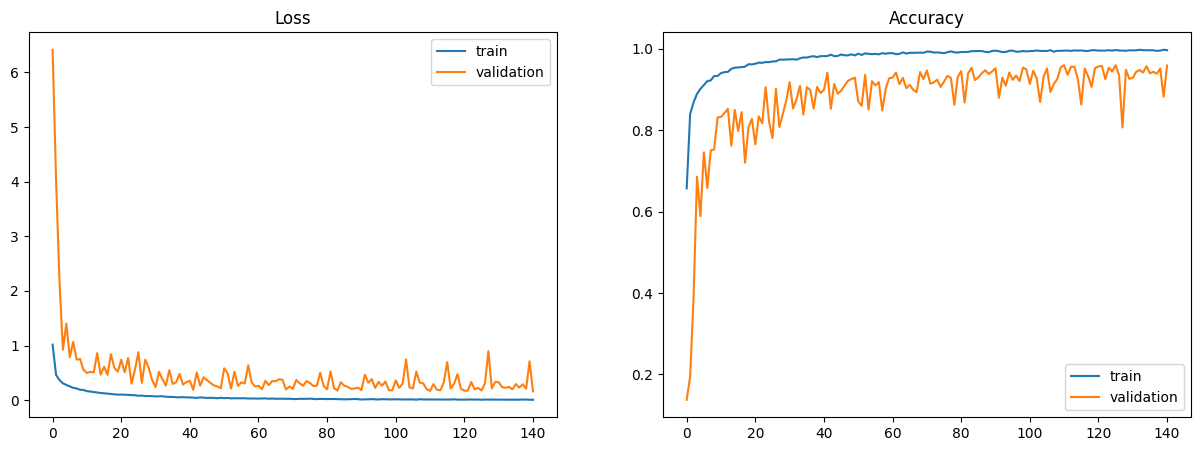

In [9]:
# Visualize training
plot_training(history)

### 5. Evaluate model

Accuracy score over the normal test set: 0.9699
Precision score over the normal test set: 0.9709
Recall score over the normal test set: 0.9699
F1 score over the normal test set: 0.97


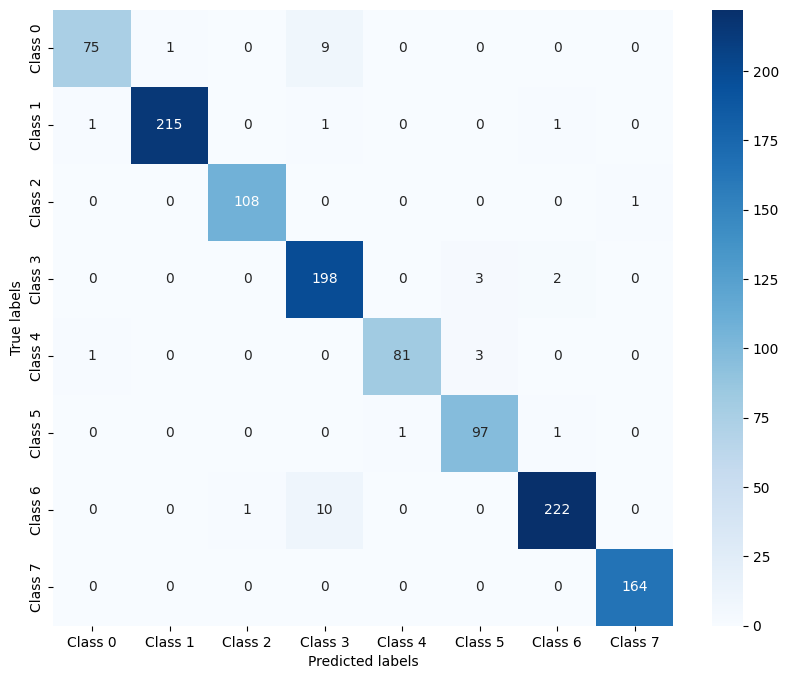


Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.88      0.93        85
           1       1.00      0.99      0.99       218
           2       0.99      0.99      0.99       109
           3       0.91      0.98      0.94       203
           4       0.99      0.95      0.97        85
           5       0.94      0.98      0.96        99
           6       0.98      0.95      0.97       233
           7       0.99      1.00      1.00       164

    accuracy                           0.97      1196
   macro avg       0.97      0.97      0.97      1196
weighted avg       0.97      0.97      0.97      1196

Class 0 ROC-AUC Score: 0.9996
Class 1 ROC-AUC Score: 1.0
Class 2 ROC-AUC Score: 0.9996
Class 3 ROC-AUC Score: 0.9974
Class 4 ROC-AUC Score: 0.9999
Class 5 ROC-AUC Score: 0.9996
Class 6 ROC-AUC Score: 0.9976
Class 7 ROC-AUC Score: 1.0

Mean ROC-AUC Score: 0.9992


In [10]:
# Predict class probabilities and get predicted classes for normal test set
test_predictions = model_2.predict(X_test, verbose=0)
test_predictions_classes = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display metrics for the normal test set
test_accuracy = accuracy_score(test_gt, test_predictions_classes)
test_precision = precision_score(test_gt, test_predictions_classes, average='weighted')
test_recall = recall_score(test_gt, test_predictions_classes, average='weighted')
test_f1 = f1_score(test_gt, test_predictions_classes, average='weighted')

print(f'Accuracy score over the normal test set: {round(test_accuracy, 4)}')
print(f'Precision score over the normal test set: {round(test_precision, 4)}')
print(f'Recall score over the normal test set: {round(test_recall, 4)}')
print(f'F1 score over the normal test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions_classes)

# Plot the confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=[f'Class {i}' for i in range(8)],
            yticklabels=[f'Class {i}' for i in range(8)], cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Classification report for detailed metrics per class
print("\nClassification Report:\n")
print(classification_report(test_gt, test_predictions_classes))

# ROC-AUC score for each class
y_test_binarized = label_binarize(test_gt, classes=range(8))
roc_auc_scores = []
for i in range(8):
    try:
        roc_auc = roc_auc_score(y_test_binarized[:, i], test_predictions[:, i])
        roc_auc_scores.append(roc_auc)
        print(f"Class {i} ROC-AUC Score: {round(roc_auc, 4)}")
    except ValueError:
        print(f"Class {i} ROC-AUC Score: Unable to calculate (not enough samples).")

# Display mean ROC-AUC score across classes
if roc_auc_scores:
    print(f"\nMean ROC-AUC Score: {round(np.mean(roc_auc_scores), 4)}")

These results indicate that both models are highly effective at predicting the labels for the specific test set they were trained on, as they achieved similar high accuracy on the local dataset. This suggests that they successfully capture the unique features of the local data.

However, when evaluated on the **Codabench** platform, the models showed drastically different performances: one achieved **19% accuracy**, while the other achieved **30% accuracy** on the Codabench test set. This significant drop, particularly in the first model, suggests that both models suffer from **overfitting** to the local dataset, though the second model may generalize slightly better. Despite their strong performance locally, these results highlight their limited ability to handle a **more diverse dataset** with characteristics that differ from the training data.
